# Fig 5 waveform shape gif

This notebook creates an animated visualizer showing how waveform shape can influence estimates.

Based on Fig 5 (a-c) of the oscillation methods paper. 

ToDo:
- label bar plots

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from fooof import Bands

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import amp_by_time
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.sim import sim_oscillation, sim_powerlaw

from bycycle.features import compute_features

In [54]:
import seaborn as sns
sns.set_context('poster')

In [55]:
# Import custom code
from code.utils import compute_abs_power, compute_pac
from code.plts import plot_timeseries, plot_bar, plot_spectra
from code.gif import clear_output, _gif_plot_output

## SETTINGS

In [56]:
n_seconds = 10
fs = 1000
cf = 10

exp = -1

In [305]:
BANDS = Bands({'alpha' : [8, 12],
               'beta' : [12, 35]})

In [306]:
burst_detection_kwargs = {
    "amplitude_fraction_threshold": 0.0,
    "amplitude_consistency_threshold": 0.0,
    "period_consistency_threshold": 0.0,
    "monotonicity_threshold": 0.0}

In [307]:
alpha_color = '#1882d9'

In [308]:
psd_range = [3, 35]

## DEFINE AXES

In [309]:
def make_axes():
    
    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 5)

    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[0:, 3:])
    
    return fig, ax1, ax2, ax3, ax4, ax5

## SIMULATE SIGNAL

In [310]:
rdsym = 0.75

In [311]:
ap = sim_powerlaw(n_seconds, fs, exp)

In [312]:
osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=rdsym)

In [313]:
filted = filter_signal(osc, fs, 'bandpass', (cf-2, cf+2))

In [314]:
freqs, powers = trim_spectrum(*compute_spectrum(osc + ap, fs), psd_range)

In [315]:
df = compute_features(osc, fs, f_range=(cf - 2, cf + 2),
                      burst_detection_kwargs=burst_detection_kwargs)

In [316]:
alpha_filt = filter_signal(osc, fs, 'bandpass', BANDS.alpha)
beta_filt = filter_signal(osc, fs, 'bandpass', BANDS.beta)

alpha = np.nanmean(amp_by_time(alpha_filt, fs))
beta = np.nanmean(amp_by_time(beta_filt, fs))

In [340]:
bins, pac = compute_pac(alpha_filt, beta_filt)
pac = np.nanmax(pac) - np.nanmin(pac)

In [342]:
# Compute comparison sine wave
sine_osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=0.5)
freqs_sine, powers_sine = trim_spectrum(*compute_spectrum(sine_osc + ap, fs), psd_range)

alpha_sine_filt = filter_signal(sine_osc, fs, 'bandpass', BANDS.alpha)
beta_sine_filt = filter_signal(sine_osc, fs, 'bandpass', BANDS.beta)
alpha_sine = np.nanmean(amp_by_time(alpha_sine_filt, fs))
beta_sine = np.nanmean(amp_by_time(beta_sine_filt, fs))

bins, pac_sine = compute_pac(alpha_sine_filt, beta_sine_filt)
pac_sine = np.nanmax(pac_sine) - np.nanmin(pac_sine)

## EXAMPLE PLOT

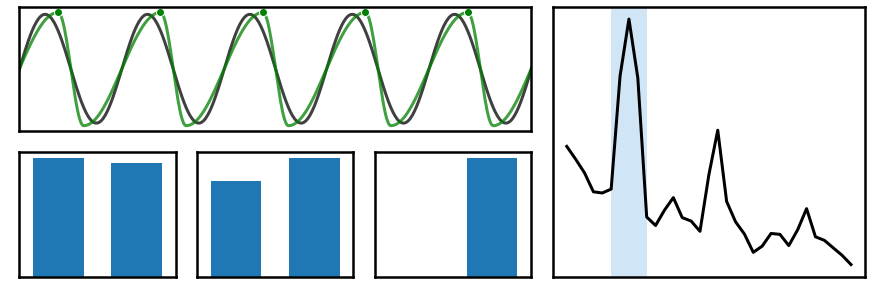

In [343]:
fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
plot_timeseries([filted, osc], colors=['black', 'green'], alpha=0.75, xlim=[1000, 1500], ax=ax1)

ax1.plot(df.sample_peak, df.volt_peak, ".",
        color='green', markersize=16, markeredgecolor='white')

plot_bar(alpha_sine, alpha, ax=ax2)
plot_bar(beta_sine, beta, ax=ax3)
plot_bar(np.nanmax(pac_sine), np.nanmax(pac), ax=ax4)
plot_spectra(freqs, powers, colors='black', 
             shade_ranges=[BANDS.alpha], shade_colors=[alpha_color],
             log_freqs=False, ax=ax5)

## BUILDER FUNCTION

In [356]:
def build_all(rdsyms, sleep=0.5, save=False):
    
    ## Setup
    
    # Precompute signals and measures
    oscs, filteds, powerss, dfs, alphas, betas, pacs = [], [], [], [], [], [], []
    for rdsym in rdsyms:
        
        osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=rdsym)
        oscs.append(osc)
        
        filteds.append(filter_signal(osc, fs, 'bandpass', (cf-2, cf+2)))
        
        freqs, powers = trim_spectrum(*compute_spectrum(osc + ap, fs), psd_range)
        powerss.append(powers)
        
        dfs.append(compute_features(osc, fs, f_range=(cf - 2, cf + 2),
                                   burst_detection_kwargs=burst_detection_kwargs))
        
        alpha_filt = filter_signal(osc, fs, 'bandpass', BANDS.alpha)
        beta_filt = filter_signal(osc, fs, 'bandpass', BANDS.beta)

        alphas.append(np.nanmean(amp_by_time(alpha_filt, fs)))
        betas.append(np.nanmean(amp_by_time(beta_filt, fs)))

        bins, pac = compute_pac(alpha_filt, beta_filt)
        pacs.append(np.nanmax(pac) - np.nanmin(pac))

    
    ## Create builds
    for b_ind, (osc, filted, powers, df, alpha, beta, pac) in \
        enumerate(zip(oscs, filteds, powerss, dfs, alphas, betas, pacs)):

        clear_output(wait=True)
        
        fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
    
        plot_timeseries([filted, osc], colors=['black', 'green'],
                        alpha=0.75, xlim=[1000, 1500], ax=ax1)

        ax1.plot(df.sample_peak, df.volt_peak, ".",
                 color='green', markersize=16, markeredgecolor='white')

        plot_bar(alpha_sine, alpha, 
                 ylim=[0, get_max_lim(alphas)], ax=ax2)
        plot_bar(beta_sine, beta,
                 ylim=[0, get_max_lim(betas)], ax=ax3)
        plot_bar(pac_sine, pac, ylim=[0, get_max_lim(pacs)], ax=ax4)
        plot_spectra(freqs, powers, colors='black', 
                     shade_ranges=[BANDS.alpha], shade_colors=[alpha_color],
                     log_freqs=False, ax=ax5)
    
        _gif_plot_output(fig, save, b_ind, 'fig1', sleep)

In [357]:
def get_max_lim(arr, buffer=0.15):
    """   """
    return np.max(arr) + buffer * np.max(arr)

## ANIMATED PLOT

In [360]:
rdsyms = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
          0.9, 0.8, 0.7, 0.6, 0.5, 
          0.4, 0.3, 0.2, 0.1, 0, 
          0.1, 0.2, 0.3, 0.4]

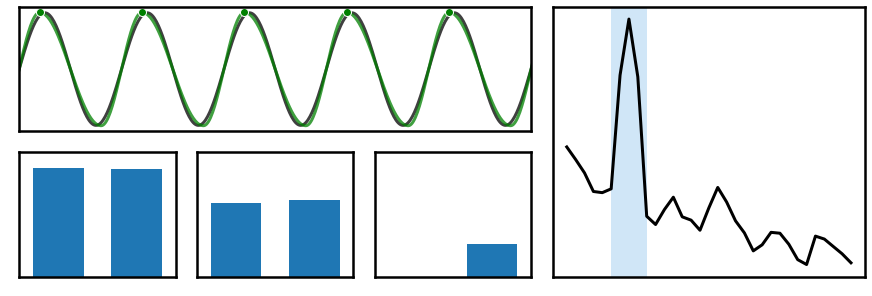

In [361]:
build_all(rdsyms)